<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TSA_Nifty_50_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pending Activities** -

Titles and axes names for all graphs
check if auto_arima works here instead of your for loop

model using ARCH

# **# Group - 8**

CH24M548 - Mounika Chowdary Pamulapati

CH24M571 - Soumya Mukherjee

CH24M577 - Surya Kandala

The steps followed to model the given Nifty 50 data were the below:

1. **Importing the dataset**.
2. **Cleaning the dataset**: Ensured that missing dates were added and forward fill of the data for the missing dates. Dropped NaN records whereever observed.
3. **Stationartiy Check**: Validated if the timeseries is stationary or not by performing ADF and KSS test. For ADF test if p<0.05, then it says the timeseries is stationary. If p>0.05 for KSS test, it indicates the timeseries is stationary.
4. **First Order Differencing & Log Differencing**: Performing first order differencing to make the timeseries stationary.
5. **ACF and PACF**: Compute Auto Correlation and Partial correlation to understand the presence of MA and AR components.
6. **Power Spectral Density**: For a process to be stationary, both mean and variance need to be independent of the absolute time. Hence, validating if Variance is dependent on the absolute time.
7. **Random Walk**: Based on the ACF and PACF values, going with ARMA model of 010 since ACF and PACF results indicate complete white noise.
8. **Akaike's Information Criteria**: Since the forecast is only a straight line, checked the AIC values for models starting from 000 till 332. Chose that model which has less AIC value
9. **Train, Test & Generate Forecast**: Generated the forecast for 122 model which got less AIC value in step 7.
10. **MSE, RMSE, MAPE**: Identify the Mean Square Error and Root Mean Square Error to check the residual details.
11. **Alternate Non-Lionear models**: Since we have variance as a function of absolute time, linear models might not be the right choice to move ahead, hence trying out the non-linear models ARCH and GARCH to model the data.

Packages Required!

In [5]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install statsmodels
!pip install scipy
!pip install scikit-learn
!pip install arch
!pip install statsforecast
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.6 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsforecast import StatsForecast

**Importing the dataset**:

Reading the Training dataset from Google Drive and set the date field as index.

In [7]:
# Generate or load your dataset
url='https://drive.google.com/file/d/16h5NCff5s-2V9lwksc9aCEKJIAn2Znyv/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
# df = pd.read_csv('NIFTY_50_2015-2023.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()

,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,
2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17
2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47
2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55
2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15


In [8]:
# Statistical Description of the data

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2016.0,1.281596e+04,3.817052e+03,7023.65,9.955450e+03,1.146808e+04,1.683017e+04,2.173765e+04
High,2016.0,1.287451e+04,3.829024e+03,7034.20,9.995938e+03,1.150275e+04,1.694861e+04,2.180145e+04
Low,2016.0,1.273479e+04,3.800429e+03,6825.80,9.894288e+03,1.139398e+04,1.670275e+04,2.167800e+04
Close,2016.0,1.280677e+04,3.816931e+03,6970.60,9.954450e+03,1.144715e+04,1.682427e+04,2.177870e+04
Shares Traded,2015.0,3.461933e+08,2.005733e+08,16610872.00,2.093599e+08,2.742842e+08,4.403760e+08,1.811564e+09
Turnover (? Cr),2015.0,1.952605e+04,9.816116e+03,805.89,1.126420e+04,1.849863e+04,2.510378e+04,7.852293e+04


**Cleaning the dataset**:

Checking for missing dates and adding them back to the dataset.
Forwardfill the values from the previous rows. -- Currently, even if stock market is not open on Saturday and Sunday, still Friday closing will be the opening for Monday. So, assuming forward fill imputation would not be a problem.

In [ ]:
start = df.index[0].date() # minimum date from the dataset
end = df.index[len(df)-1].date() # maximum date from the dataset
new_dates = pd.date_range(start=start,end=end,freq='D') # Generating new dates starting from minimum and extending till maximum

# Re-indexing new dates with the old dates

df = df.reindex(new_dates)
df = df.rename_axis('Fin_Dt')
df.reset_index(inplace=True)
df = df.ffill()

# Maintaining one date column as index and other date column for our reference.

df['Date'] = pd.to_datetime(df['Fin_Dt'])
df.set_index('Date', inplace=True)

df.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55


**Plot the training dataset**.

Graph is being plotted for the Close values as training and testing to be done for that column of the dataset.

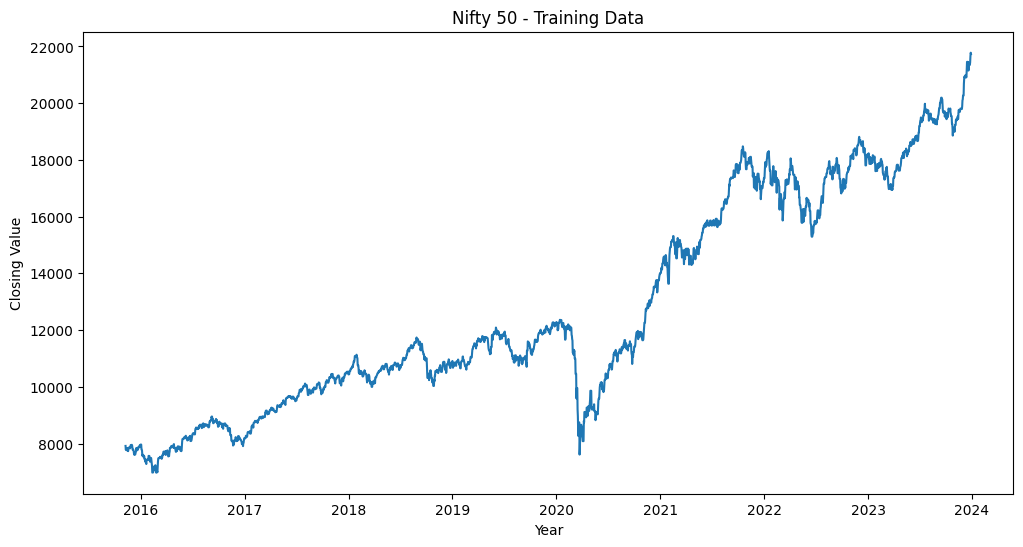

In [ ]:
# Use the 'Close' prices as the target variable and plot the Original Data
final_data = df[['Fin_Dt','Close']] ## will be used at a later point in the code.

plt.figure(figsize=(12, 6))
plt.plot(final_data['Close'])
plt.title("Nifty 50 - Training Data")
plt.xlabel("Year")
plt.ylabel("Closing Value")
plt.show()


**Stationarity Check**:

To check if the data is stationary, here we used Augmented Dickey Fuller's Test.
This test helps us understand if there is a change in the Mean with absolute time. But, it doesn't give any information on the variance of the timeseries.


In [ ]:
# Perform the ADF test
adf_res = adfuller(df['Close'], autolag='AIC')

print(f"ADF Statistic: {adf_res[0]}")
print(f"p-value: {adf_res[1]}")
print(f"No Lags Used: {adf_res[2]}")
print(f"Number of observations used: {adf_res[3]}")
print(f"Critical Values: {adf_res[4]}")

if adf_res[1] <= 0.05:
    print("Reject the null hypothesis")
    print("The data is stationary")

else:
    print("The null hypothesis cannot be rejected")
    print("The data is not stationary")

ADF Statistic: 0.2840356873512916
p-value: 0.9766000806277764
No Lags Used: 13
Number of observations used: 2959
Critical Values: {'1%': -3.432561889805549, '5%': -2.862517267814074, '10%': -2.5672902261937134}
The null hypothesis cannot be rejected
The data is not stationary


**First Order Differencing**:

Since the p-value is greater than 0.05, we fail to reject the null hypothesis, which means the data is not stationary.

Lets do the first order differencing of the data to remove the varying Mean component. Below are the different ways that can be used to remove the varying mean and variance components.

**Differencing**: Subtracting the current observation from the previous one to achieve stationarity.
**Detrending**: Another technique for removing seasonality from time series data.
**Seasonal decomposition**: Decomposing the time series into seasonal, trend, and residual components.
**Log transformation**: Taking the natural logarithm of the data to stabilize variance.
**Log difference**: Combining log transformation and differencing to address both trend and seasonality.

In [ ]:
# Seasonal adjustment
df['Seasonal_Adjusted'] = df['Close'].diff(periods=7).dropna() ## An integer that controls the number of periods over which the difference is calculated.

# Differencing
df['Differenced'] = df['Close'].diff().dropna()

# Log Differencing
df['Log_Differenced'] = np.log(df['Close']/df['Close'].shift(1)).dropna()

df.head(10)

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,-62.75,-0.008051
2015-11-14,2015-11-14,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,0.00,0.000000
2015-11-15,2015-11-15,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,0.00,0.000000
2015-11-16,2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15,-108.6,44.35,0.005697
2015-11-17,2015-11-17,7848.75,7860.45,7793.00,7837.55,149451211.0,6367.14,54.2,30.95,0.003957


**Plot the data**

Validate the difference between actual, differenced, seasonal, and log differenced data.

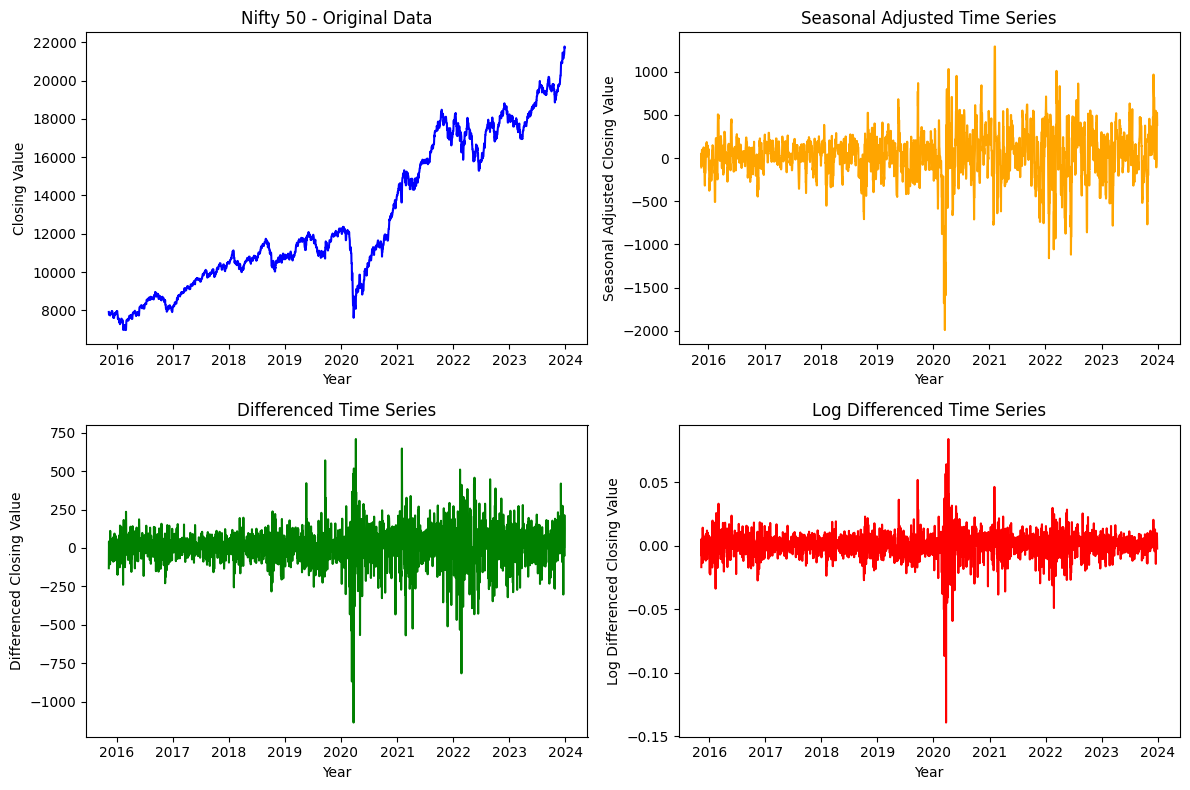

In [ ]:
# Visualize the results
plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(2, 2, 1)
plt.plot(final_data['Close'], color = 'blue')
plt.title('Nifty 50 - Original Data')
plt.xlabel('Year')
plt.ylabel('Closing Value')

# Seasonal Adjusted
plt.subplot(2, 2, 2)
plt.plot(df['Seasonal_Adjusted'], color = 'orange')
plt.title('Seasonal Adjusted Time Series')
plt.xlabel('Year')
plt.ylabel('Seasonal Adjusted Closing Value')

# Differenced
plt.subplot(2, 2, 3)
plt.plot(df['Differenced'], color = 'green')
plt.title('Differenced Time Series')
plt.xlabel('Year')
plt.ylabel('Differenced Closing Value')

# Log Differenced
plt.subplot(2, 2, 4)
plt.plot(df['Log_Differenced'], color = 'red')
plt.title('Log Differenced Time Series')
plt.xlabel('Year')
plt.ylabel('Log Differenced Closing Value')

plt.tight_layout()
plt.show()

**Stationary check post differencing**.

The differenced data has approximately more or less constant mean when we apply windows.

But, lets calculate the ADF value again to re-confirm

In [ ]:
# Perform the ADF test

adf_res_mod = adfuller(df['Differenced'].dropna(), autolag='AIC')
print(f"ADF Statistic: {adf_res_mod[0]}")
print(f"p-value: {adf_res_mod[1]}")
print(f"#Lags Used: {adf_res_mod[2]}")
print(f"Number of Observations Used: {adf_res_mod[3]}")
print(f"Critical Values: {adf_res_mod[4]}")


ADF Statistic: -13.895226266266175
p-value: 5.868297702786577e-26
#Lags Used: 12
Number of Observations Used: 2959
Critical Values: {'1%': -3.432561889805549, '5%': -2.862517267814074, '10%': -2.5672902261937134}


The p-value obtained is less than the significance level of 0.05, and the ADF statistic is less than any of the critical values.
we reject the Null hypothesis in favor of the alternative. So, the time series is, in fact, stationary

**Histogram** representation of actual data and its differenced form.
Differenced data is approximately following Guassian Distribution

Variance plot as well for the differenced and log differenced data. Is the differenced data stationary? Though the differenced data follows Gaussian distribution, we see changes in the variance plot.


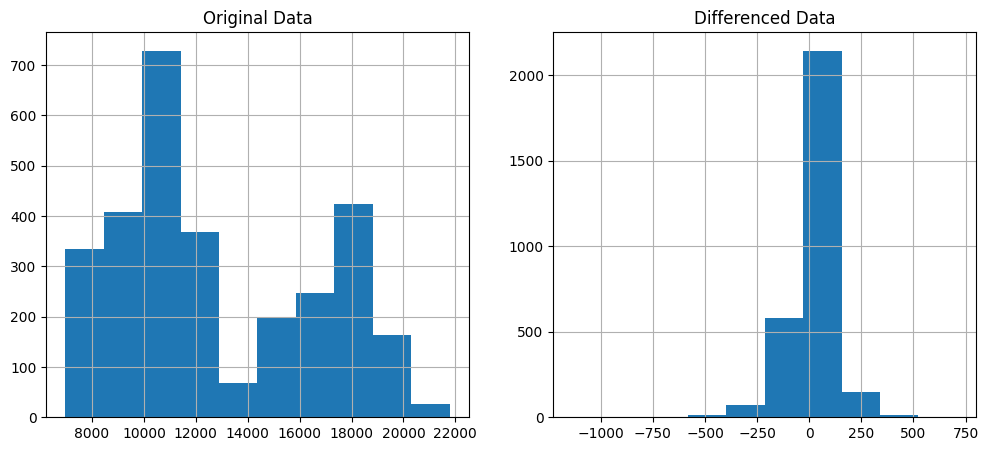

In [ ]:
plt.figure(figsize=(12, 5))

## Histogram of the Original data

plt.subplot(1,2,1)
final_data['Close'].hist()
plt.title("Original Data")

## Histogram of the Differenced data

plt.subplot(1,2,2)
df['Differenced'].dropna().hist()
plt.title("Differenced Data")
plt.show()


<Axes: xlabel='Date'>

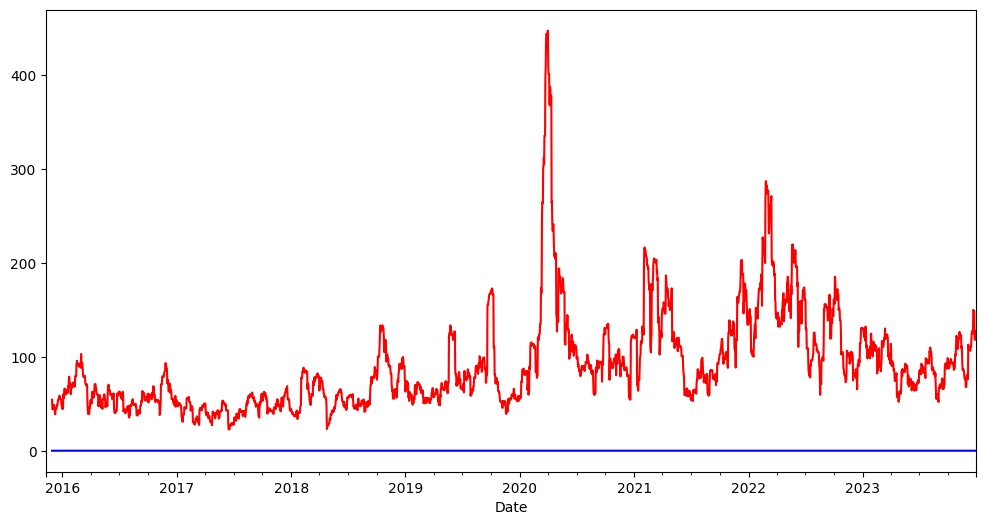

In [ ]:
## Now lets check how is the variance. Is the differenced data stationary or not
plt.figure(figsize=(12, 6))
# add the 20 day rolling standard deviation:
df['Differenced'].dropna().rolling(window=20).std().plot(style='r')
df['Log_Differenced'].dropna().rolling(window=20).std().plot(style='b')
# So the Variance changing over time.


**ACF and PACF** Plots

Lets check ACF and PACF details of the differenced data for 20 lags

<Figure size 1200x600 with 0 Axes>

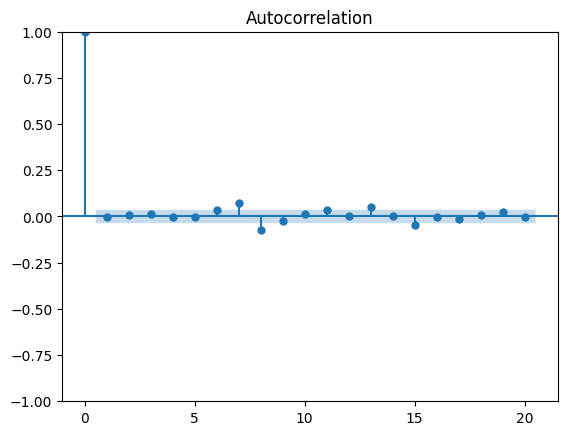

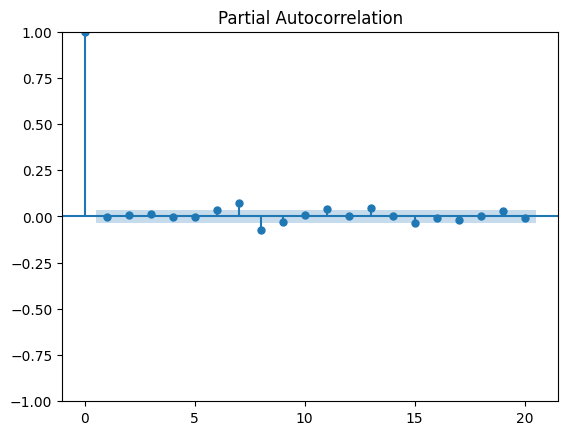

In [ ]:
# ACF and PACF of the differenced series
plt.figure(figsize=(12, 6))

plot_acf(df['Differenced'].dropna(), lags=20)

plot_pacf(df['Differenced'].dropna(), lags=20)
plt.show()

**Power Spectral Density** - **Welch Method** using **Hann** window.


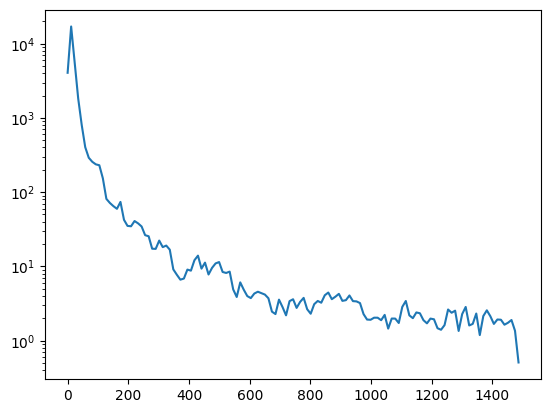

In [ ]:
# PSD of the Differenced timeseries
f,PSD = signal.welch(df['Close'],fs=len(df['Differenced'].dropna()), window='hann')
plt.semilogy(f,PSD)
plt.show()

# PSD shows varying frequency details

**Random walk with drift**

The ACF and PACF happens to show pure white noise.

If after differencing your time series, both the ACF and PACF plots indicate only white noise, then the most likely model to identify is a simple ARIMA(0,1,0) model, which essentially represents a "random walk with drift" where the only significant component is the first difference of the data, meaning the change between consecutive observations is essentially random noise

ARIMA(0,1,0):
"0" for AR: No autoregressive component (no dependence on past values).
"1" for I: One order of differencing is required to achieve stationarity.
"0" for MA: No moving average component.

In [ ]:
# fit model
model = ARIMA(df['Differenced'].dropna(), order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:            Differenced   No. Observations:                 2972
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -19099.227
Date:                Wed, 25 Dec 2024   AIC                          38200.454
Time:                        15:13:07   BIC                          38206.450
Sample:                    11-10-2015   HQIC                         38202.612
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.245e+04    232.361     96.602      0.000     2.2e+04    2.29e+04
Ljung-Box (L1) (Q):                 756.22   Jarque-Bera (JB):             13991.86
Prob(Q):                              0.00   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**Plot** the Residuals of Random Walk with Drift

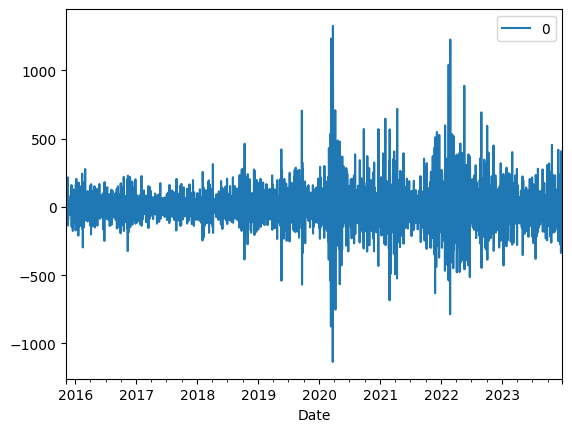

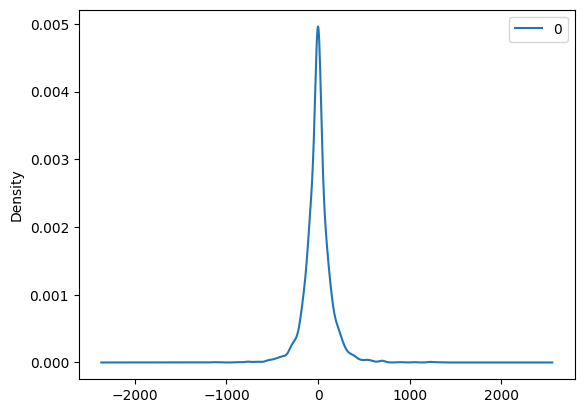

In [ ]:
# line plot of residuals
residuals.plot()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()


Import Test Data

In [ ]:
# Import Test dataset

url='https://drive.google.com/file/d/1L-hcnQLVffdxz1PwwMTJkB6AmB2BkjBn/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test = pd.read_csv(url)
## df_test = pd.read_csv('NIFTY_50_2024.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='mixed')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)


df_test.head()

,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,
2024-01-01,21727.75,21834.35,21680.85,21741.90,153995217.0,14184.09
2024-01-02,21751.35,21755.60,21555.65,21665.80,263711568.0,25316.13
2024-01-03,21661.10,21677.00,21500.35,21517.35,311933117.0,32329.23
2024-01-04,21605.80,21685.65,21564.55,21658.60,339172697.0,30868.15
2024-01-05,21705.75,21749.60,21629.20,21710.80,309303266.0,26554.49


In [ ]:
# Check for missing dates and add them to the dataset
# Identify Start and End dates from the dataset and generate new dates from those dates which will be daily dates

start = df_test.index[0].date()
end = df_test.index[len(df_test)-1].date()
new_dates = pd.date_range(start=start,end=end,freq='D')

# Re-indexing new dates with the old dates

df_test = df_test.reindex(new_dates)
df_test = df_test.rename_axis('Fin_Dt')
df_test.reset_index(inplace=True)
df_test = df_test.ffill()

df_test['Date'] = pd.to_datetime(df_test['Fin_Dt'])
df_test.set_index('Date', inplace=True)

df_test.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,,
2024-01-01,2024-01-01,21727.75,21834.35,21680.85,21741.90,153995217.0,14184.09
2024-01-02,2024-01-02,21751.35,21755.60,21555.65,21665.80,263711568.0,25316.13
2024-01-03,2024-01-03,21661.10,21677.00,21500.35,21517.35,311933117.0,32329.23
2024-01-04,2024-01-04,21605.80,21685.65,21564.55,21658.60,339172697.0,30868.15
2024-01-05,2024-01-05,21705.75,21749.60,21629.20,21710.80,309303266.0,26554.49


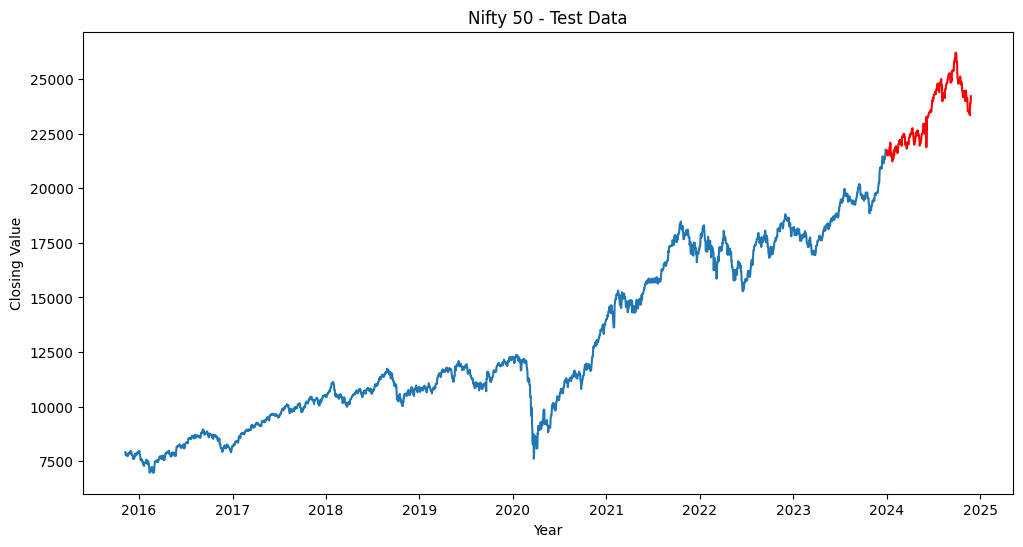

In [ ]:
# Use the 'Close' prices as the target variable and plot the Original Data
final_data_test = df_test[['Fin_Dt','Close']]

close_plot_test = final_data_test['Close']

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Observed')
plt.plot(close_plot_test, color = 'red', label = 'Test')
plt.title("Nifty 50 - Test Data")
plt.xlabel("Year")
plt.ylabel("Closing Value")
plt.show()

Get the train and test datasets

In [ ]:
# split into train and test sets
X = df['Differenced'].dropna().values
Y = df_test['Close'].dropna().values
train, test = X, Y


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2973
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -18072.827
Date:                Wed, 25 Dec 2024   AIC                          36147.655
Time:                        16:13:43   BIC                          36153.652
Sample:                    11-09-2015   HQIC                         36149.813
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.12e+04    107.483    104.221      0.000     1.1e+04    1.14e+04
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             20769.64
Prob(Q):                              0.84   Pr

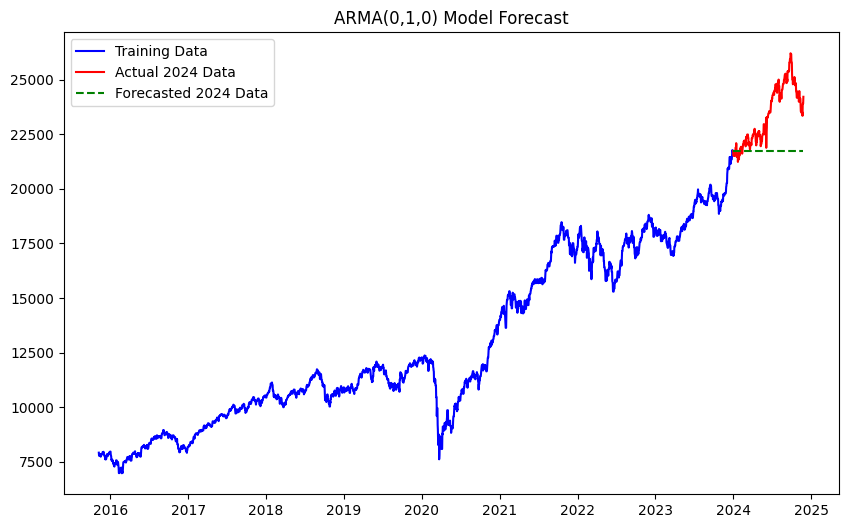

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,-62.75,-0.008051


In [ ]:
# Fit ARMA(0,1,0) model
model = ARIMA(df['Close'].dropna(), order=(0,1,0))
fitted_model = model.fit()
print(fitted_model.summary())

# Forecast next 20 steps
forecast = fitted_model.get_forecast(steps=330)
forecast_summary = forecast.summary_frame()

forecast_vals = fitted_model.forecast(steps=330)

# Set forecast index to a date range for 2024
forecast_summary.index = pd.date_range(start='2024-01-01', periods=330, freq='D')

# print(forecast_vals)

# Plot forecast
# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
plt.plot(df['Close'].dropna().index, df['Close'], label='Training Data', color='blue')
plt.plot(df_test['Close'].index, df_test['Close'], label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_vals, label='Forecasted 2024 Data', color='green', linestyle='--')

#plt.plot(np.arange(len(df['Close']), len(df['Close']) + 300), forecast.predicted_mean, label="Forecast", color='orange')

plt.title("ARMA(0,1,0) Model Forecast")
plt.legend()
plt.show()

df.head()

Checking MSE and RMSE

In [ ]:
# Evaluate the model using error metrics

mae = mean_absolute_error(df_test['Close'], forecast_vals)
rmse = np.sqrt(mean_squared_error(df_test['Close'], forecast_vals))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 1694.6612121212108
Root Mean Squared Error (RMSE): 2122.564876133103


Lets choose an appropriate model by identifying AIC values for a set of models that include variations of AR, MA, ARMA, and ARIMA

Checking AIC Values for various models. There is some issue in installing auto_arima related libraries.
Hence tried manually validating AIC for sample models.

In [ ]:
## Check if auto_arima works here
## Set the initial parameters for p,d,q
p = 1
d = 1
q = 1

#AIC values to be validated until these values of p,d,q
max_p = 4
max_q = 2
max_d = 3

# print(p,d,q)

for d in range(max_d+1):
    for q in range(max_q+1):
        for p in range(max_p):
            model = ARIMA(df['Close'].dropna(), order=(p,d,q))
            fitted_model = model.fit()
            print("ARIMA Order - ", p,d,q, fitted_model.aic)
            #print(p,d,q)
            p+=1
        q+=1
    d+=1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA Order -  0 0 0 78275.87141754924
ARIMA Order -  1 0 0 36172.21832359528


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  2 0 0 36173.94284683875


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  3 0 0 36175.79565320157


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order -  0 0 1 53449.45457250668


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  1 0 1 36173.942967225514


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA Order -  2 0 1 36170.330929319025


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  3 0 1 36172.02207318398


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 0 2 50085.88744956731


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  1 0 2 36175.77743591025


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  2 0 2 36172.055402863494


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Order -  3 0 2 36169.44799078931
ARIMA Order -  0 1 0 36147.65493061466


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA Order -  1 1 0 36149.64045066121


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  2 1 0 36151.476679546424


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 1 0 36152.532327300774


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 1 1 36149.64124635637


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA Order -  1 1 1 36151.640762208874


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA Order -  2 1 1 36150.458433485845


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 1 1 36154.53298699879


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 1 2 36151.47756024068


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  1 1 2 36153.233602628534


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  2 1 2 36143.18909466001


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 1 2 36142.40044256163
ARIMA Order -  0 2 0 38200.45421091947
ARIMA Order -  1 2 0 37329.119582075204


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA Order -  2 2 0 36960.219752048375


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 2 0 36785.640951637964


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 2 1 36139.45827182513


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  1 2 1 36141.24042694962


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  2 2 1 36143.1369527887


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 2 1 36144.349000005524


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 2 2 36141.23878367242


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA Order -  1 2 2 36137.73064053982


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA Order -  2 2 2 36139.30156515682


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA Order -  3 2 2 36146.93878688694
ARIMA Order -  0 3 0 41459.01707893583
ARIMA Order -  1 3 0 39709.95680906567


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA Order -  2 3 0 38814.029916479965


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 3 0 38299.2248117073


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order -  0 3 1 38197.49130283177


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  1 3 1 37328.276765285525


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  2 3 1 36960.040174613074


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  3 3 1 36785.9014245671


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Order -  0 3 2 36154.77614075573


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order -  1 3 2 36210.0672082301


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order -  2 3 2 36169.54276880002


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA Order -  3 3 2 36963.98312402523


As observed AIC value is less for ARIMA Order -  1 2 2 36137.73064054128.
So lets try to fit 1,2,2 and check the output.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

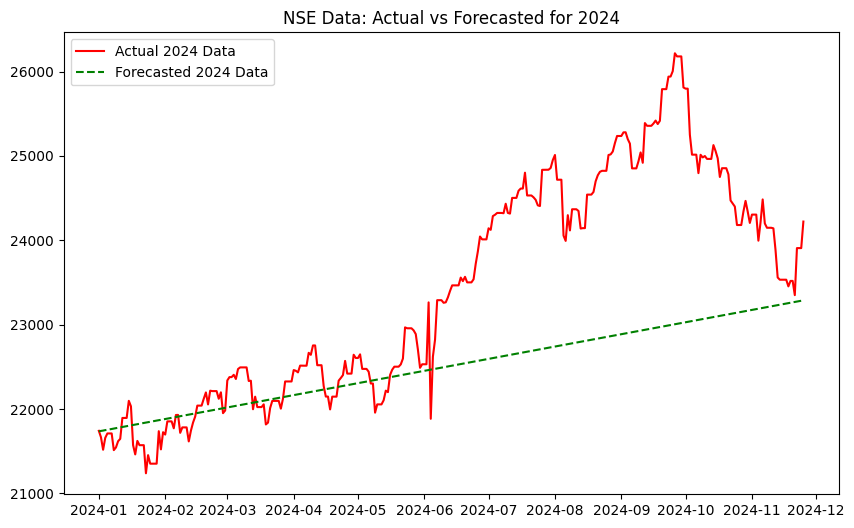

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,-62.75,-0.008051


In [ ]:
# Forecast next steps based on the length of the forecast
train_data = df['Close'].dropna()
test_data = df_test['Close']
forecast_steps = len(test_data)

model = ARIMA(train_data, order=(1,2,2))
fitted_model = model.fit()
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_summary = forecast.summary_frame()

forecast_vals = fitted_model.forecast(steps=forecast_steps)

# Set forecast index to a date range for 2024
forecast_summary.index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='D')

# print(forecast_vals)

# Plot forecast
# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
#plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_vals, label='Forecasted 2024 Data', color='green', linestyle='--')
plt.title('NSE Data: Actual vs Forecasted for 2024')
plt.legend()
plt.show()

df.head()

In [ ]:
# Evaluate the model using error metrics

mae = mean_absolute_error(test_data, forecast_vals)
rmse = np.sqrt(mean_squared_error(test_data, forecast_vals))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 963.431497088524
Root Mean Squared Error (RMSE): 1298.4844777642281


As observed from the graph, trend is being recognized but its not able to model the seasonality.
Lets try SARIMA and see how it goes for the same ARIMA order 1,2,2

In [ ]:
seasonal_order = (1, 2, 2, 100)  # 252 trading days in a year (seasonality for daily data)
model = SARIMAX(df['Close'].dropna(), order=(1, 2, 2), seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecast the data for 2024 (forecasting steps = length of test data)
forecast_steps = len(df_test['Close'].dropna())
forecast_Values = model_fit.forecast(steps=forecast_steps)

# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
#plt.plot(df.index, train_data, label='Training Data', color='blue')
plt.plot(df_test.index, test_data, label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_Values, label='Forecasted 2024 Data', color='green', linestyle='--')
plt.title('NSE Data: Actual vs Forecasted for 2024')
plt.legend()
plt.show()

df.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible start

 Though we differenced the data and assumed the process to be stationary, as we have seen that there is still varying component of the Variance with absolute time. Hence, we will not be able to fit a linear model. Hence, lets try ARCH model to fit the data.

In [ ]:
# square the dataset
df['Squared'] = df['Close']**2

df.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Seasonal_Adjusted,Differenced,Log_Differenced,Squared
Date,,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,NaN,NaN,NaN,6.265039e+07
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,NaN,-131.85,-0.016798,6.058054e+07
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,41.65,0.005337,6.123062e+07
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,NaN,0.00,0.000000,6.123062e+07
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,NaN,-62.75,-0.008051,6.025253e+07


<Figure size 1200x600 with 0 Axes>

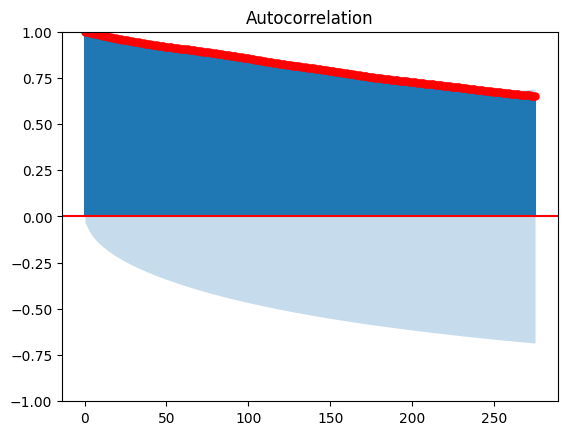

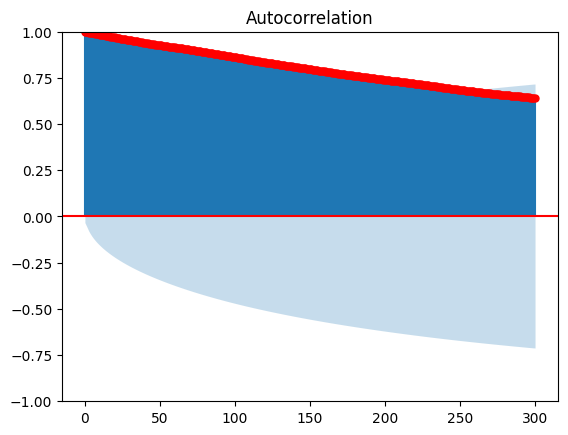

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(df['Squared'].dropna(), lags=275, color = 'red')
plot_acf(df['Close'].dropna(), lags=300, color = 'red')
plt.show()

In [ ]:

train, test = X, Y

model = arch_model(train, mean='Zero', vol='ARCH', p=1)
# fit model
model_fit = model.fit()

print(model_fit.summary())

yhat = model_fit.forecast(horizon=12)
yhat


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.118e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: 18206.54518138452
Iteration:      2,   Func. Count:      9,   Neg. LLF: 18028.22127144448
Iteration:      3,   Func. Count:     12,   Neg. LLF: 18028.221169722987
Iteration:      4,   Func. Count:     15,   Neg. LLF: 18028.22116781457
Iteration:      5,   Func. Count:     18,   Neg. LLF: 18028.22115933145
Iteration:      6,   Func. Count:     21,   Neg. LLF: 18028.221107417055
Iteration:      7,   Func. Count:     24,   Neg. LLF: 18028.220847612614
Iteration:      8,   Func. Count:     27,   Neg. LLF: 18028.21976999016
Iteration:      9,   Func. Count:     30,   Neg. LLF: 18028.21450479301
Iteration:     10,   Func. Count:     33,   Neg. LLF: 18028.19553834081
Iteration:     11,   Func. Count:     36,   Neg. LLF: 18028.15893034847
Iteration:     12,   Func. Count:     39,   Neg. LLF: 18028.152185158942
Iteration:     13,   Func. Count:     41,   Neg. LLF: 18028.152185158684
Optimization terminated successfully    (Exit mode 0)
     